In [1]:
import calendar
import dataclasses
from pprint import pprint
import shelve

import matplotlib.pyplot as plt
import numpy as np
import yaml
from astropy.table import Table

import core

In [2]:
with shelve.open("climbing_days") as data:
    climbing_days: dict[str, core.ClimbingDay] = dict(data)

In [3]:
sorted(climbing_days.keys())[:10]

['2021-04-07',
 '2021-04-09',
 '2021-04-24',
 '2021-05-07',
 '2021-05-08',
 '2021-05-09',
 '2021-05-13',
 '2021-05-14',
 '2021-05-24',
 '2021-06-05']

In [4]:
climbing_day = climbing_days["2024-04-09"]

In [5]:
type(climbing_day)

core.ClimbingDay

In [6]:
pprint(climbing_days["2024-05-18"])

ClimbingDay(date='2024-05-18',
            log_text='Sesame, Centerpiece, Social O (TA, AS usual 1h), Restless Native (TA, first try in many years, stopped at low crux not very close, beta all wrong)',
            place_and_climbers='TA AS Rumney w/ Hillary',
            climb_entries=[ClimbEntry(name_approx='Sesame',
                                      comment='',
                                      climbers=['TA', 'AS'],
                                      climb_info=ClimbInfo(name='Sesame Street',
                                                           grade='10b',
                                                           aliases=['Sesame '
                                                                    'Street',
                                                                    'Sesame']),
                                      climb_events=[ClimbEvent(climber='TA',
                                                               hang=False),
                           

In [7]:
pprint(climbing_days["2024-05-18"].climb_entries[0])

ClimbEntry(name_approx='Sesame',
           comment='',
           climbers=['TA', 'AS'],
           climb_info=ClimbInfo(name='Sesame Street',
                                grade='10b',
                                aliases=['Sesame Street', 'Sesame']),
           climb_events=[ClimbEvent(climber='TA', hang=False),
                         ClimbEvent(climber='AS', hang=False)],
           idx_entry_start=0)


In [8]:
climbing_days["2024-05-18"].climb_entries[0].climb_events[0]

ClimbEvent(climber='TA', hang=False)

In [9]:
import re
from functools import cached_property


class Grade:
    def __init__(self, grade):
        if isinstance(grade, str):
            self.grade = grade
        else:
            self.grade = grade.grade

    @cached_property
    def number_mod(self):
        grade_str = self.grade
        if grade_str.startswith("5."):
            grade_str = grade_str[2:]
        number, modifier = re.match(r"(\d+)([^\d]*)", grade_str).groups()
        number = int(number)
        if modifier == "-":
            modifier = "a/b"
        if modifier == "+":
            modifier = "c/d"
        return number, modifier

    def __repr__(self):
        return self.grade

    def __hash__(self):
        return hash(self.grade)

    def __eq__(self, other):
        return self.number_mod == Grade(other).number_mod

    def __ne__(self, other):
        return not self == other

    def __le__(self, other):
        return self.number_mod <= Grade(other).number_mod

    def __gt__(self, other):
        return not self <= other

    def __lt__(self, other):
        return self.number_mod < Grade(other).number_mod

    def __ge__(self, other):
        return not self < other

In [10]:
g1 = Grade("5.10-")
print(g1)
g2 = Grade("5.10b")
print(g1 < "12a")
print("12a" < g1)

5.10-
True
False


In [11]:
"9+" < g1

True

In [12]:
def get_climbs_table(climbing_days: dict[str, core.ClimbingDay]) -> Table:
    rows = []
    for date in climbing_days:
        for entry in climbing_days[date].climb_entries:
            for event in entry.climb_events:
                rows.append(
                    (
                        date,
                        entry.climb_info.name,
                        Grade(entry.climb_info.grade),
                        event.climber,
                        "" if event.hang else "✓",
                    )
                )
    climbs = Table(rows=rows, names=("date", "name", "grade", "climber", "send"))
    climbs.sort("date")
    climbs["year"] = np.array([int(date.split("-")[0]) for date in climbs["date"]])
    climbs["month"] = np.array([int(date.split("-")[1]) for date in climbs["date"]])
    climbs["grade_num"] = np.array([grade.number_mod[0] for grade in climbs["grade"]])

    return climbs

In [13]:
climbs = get_climbs_table(climbing_days)

In [14]:
climbs

date,name,grade,climber,send,year,month,grade_num
str10,str24,object,str2,str1,int64,int64,int64
2021-04-07,Holderness Arete,10b,TA,✓,2021,4,10
2021-04-07,Idiot Deluxe,10c,AS,✓,2021,4,10
2021-04-07,Idiot Deluxe,10c,TA,✓,2021,4,10
2021-04-07,Holderness Arete,10b,AS,✓,2021,4,10
2021-04-09,Masterpiece,10a,TA,✓,2021,4,10
2021-04-09,Metamorphosis,8,AS,✓,2021,4,8
2021-04-09,Men in White Suits,9,TA,✓,2021,4,9
2021-04-09,Men in White Suits,9,AS,✓,2021,4,9
2021-04-09,Masterpiece,10a,AS,,2021,4,10


In [15]:
climbs12 = climbs[(climbs["grade"] >= "12a") & (climbs["climber"] == "TA")]
climbs11 = climbs[
    (climbs["grade"] >= "11a") & (climbs["grade"] < "12a") & (climbs["climber"] == "TA")
]

In [16]:
def print_climbs(climbs, start, stop):
    ok = (climbs["date"] >= start) & (climbs["date"] < stop)
    climbs = climbs[ok]
    ok = climbs["name"] == "Restless Native"
    climbs["send"][ok] = ""
    del climbs["climber"]
    print(len(climbs))
    climbs.pprint_all()

In [17]:
print_climbs(climbs11, "2022-01-01", "2022-12-31")

44
   date              name          grade send year month grade_num
---------- ----------------------- ----- ---- ---- ----- ---------
2022-04-15           Sally's Alley   11c    ✓ 2022     4        11
2022-04-17           Cereal Killer   11c    ✓ 2022     4        11
2022-04-22                 Mitosis   11d      2022     4        11
2022-04-23           Sally's Alley   11c    ✓ 2022     4        11
2022-04-23           Sally's Alley   11c    ✓ 2022     4        11
2022-05-01             White Rhino   11c    ✓ 2022     5        11
2022-05-01         Captain Fingers   11c      2022     5        11
2022-05-08          Arm and Hammer   11c      2022     5        11
2022-05-13               Sky Pilot   11b    ✓ 2022     5        11
2022-05-13  Blueballs at Christmas   11b    ✓ 2022     5        11
2022-05-13          Arm and Hammer   11c    ✓ 2022     5        11
2022-05-13               Sky Pilot   11b    ✓ 2022     5        11
2022-05-13          License to Ill   11a    ✓ 2022     5   

In [18]:
# 2023 WRIST injury
print_climbs(climbs11, "2023-01-01", "2023-12-31")

40
   date          name      grade send year month grade_num
---------- --------------- ----- ---- ---- ----- ---------
2023-04-08     White Rhino   11c      2023     4        11
2023-04-09   Cereal Killer   11c    ✓ 2023     4        11
2023-06-16       Tropicana   11a    ✓ 2023     6        11
2023-06-16     Black Mamba   11c    ✓ 2023     6        11
2023-06-18   Sally's Alley   11c    ✓ 2023     6        11
2023-06-18     Black Mamba   11c      2023     6        11
2023-06-22     Black Mamba   11c      2023     6        11
2023-06-22       Tropicana   11a    ✓ 2023     6        11
2023-06-23     Black Mamba   11c    ✓ 2023     6        11
2023-06-23   F'ing the Dog   11a    ✓ 2023     6        11
2023-06-23   F'ing the Dog   11a    ✓ 2023     6        11
2023-06-30     Know Ethics   11a    ✓ 2023     6        11
2023-06-30   Cereal Killer   11c    ✓ 2023     6        11
2023-07-01   Cereal Killer   11c    ✓ 2023     7        11
2023-07-30   Cereal Killer   11c    ✓ 2023     7     

In [19]:
print_climbs(climbs11, "2024-01-01", "2024-06-31")

11
   date         name      grade send year month grade_num
---------- -------------- ----- ---- ---- ----- ---------
2024-04-09  Cereal Killer   11c    ✓ 2024     4        11
2024-04-17      Sky Pilot   11b    ✓ 2024     4        11
2024-04-17 License to Ill   11a    ✓ 2024     4        11
2024-04-21  Cereal Killer   11c    ✓ 2024     4        11
2024-04-23    White Rhino   11c    ✓ 2024     4        11
2024-04-30      Sky Pilot   11b    ✓ 2024     4        11
2024-04-30 License to Ill   11a    ✓ 2024     4        11
2024-05-03    White Rhino   11c    ✓ 2024     5        11
2024-05-25  Sally's Alley   11c    ✓ 2024     5        11
2024-06-01  Sally's Alley   11c    ✓ 2024     6        11
2024-06-01      Tropicana   11a    ✓ 2024     6        11


In [20]:
import collections

climb_counts = collections.defaultdict(int)

In [21]:
cgs = climbs[climbs["climber"] == "TA"].group_by(["year", "month", "grade_num"])
for cg in cgs.groups:
    key = (cg["year"][0], cg["month"][0], cg["grade_num"][0])
    climb_counts[key] = len(cg)

In [22]:
int()

0

In [23]:
def filter_climbs(climbs, climber, grade_min, grade_max):
    ok = np.ones(len(climbs), dtype=bool)
    if climber:
        ok &= climbs["climber"] == climber
    if grade_min:
        ok &= climbs["grade"] >= grade_min
    if grade_max:
        ok &= climbs["grade"] < grade_max
    climbs = climbs[ok]
    return climbs

In [24]:
# data from https://allisonhorst.github.io/palmerpenguins/


def grouped_bar_chart(
    climbs, climber=None, grade_min=None, grade_max=None, func=len, title="Climb counts"
):
    months = list(range(1, 13))
    month_names = [calendar.month_abbr[ii] for ii in months]
    years = sorted(set(climbs["year"]))

    climbs = filter_climbs(climbs, climber, grade_min, grade_max)

    climb_counts = collections.defaultdict(int)
    climbs_grouped = climbs.group_by(["year", "month"])
    for cg in climbs_grouped.groups:
        key = (cg["year"][0], cg["month"][0])
        climb_counts[key] = func(cg)

    climbs_by_month = {}
    for year in years:
        climbs_by_month[year] = [climb_counts[year, month] for month in months]

    x = np.arange(len(months))  # the label locations
    width = 0.15  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout="constrained")

    for year, climb_by_month in climbs_by_month.items():
        offset = width * multiplier
        label = f"{year}: {sum(climb_by_month)}"
        ax.bar(x + offset, climb_by_month, width, label=label)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    title_words = [title, "by month"]
    if climber:
        title_words.append(f"by {climber}")
    match grade_min, grade_max:
        case None, None:
            pass
        case None, _:
            title_words.append(f"easier than {grade_max}")
        case _, None:
            title_words.append(f"harder than {grade_min}")
        case _, _:
            title_words.append(f"from {grade_min} to < {grade_max}")

    ax.set_ylabel("Number")
    ax.set_title(" ".join(title_words))
    ax.set_xticks(x + width, month_names)
    ax.legend(loc="upper left")
    # ax.set_ylim(0, 250)

    plt.show()

In [25]:
def count_days(climbs):
    return len(set(climbs["date"]))

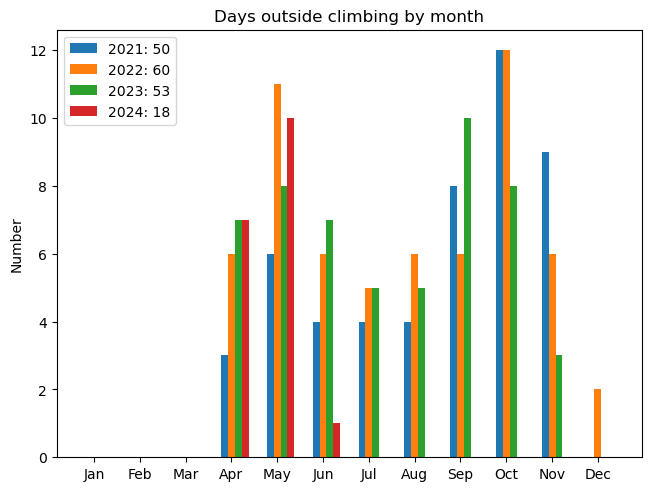

In [26]:
grouped_bar_chart(climbs, func=count_days, title="Days outside climbing")

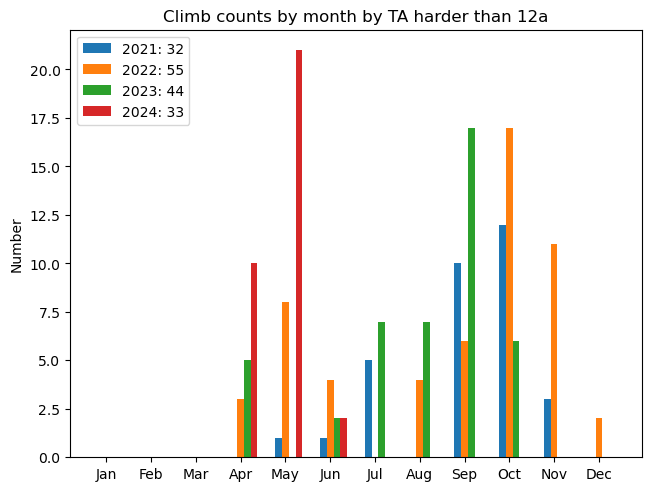

In [28]:
grouped_bar_chart(climbs, climber="TA", grade_min="12a")

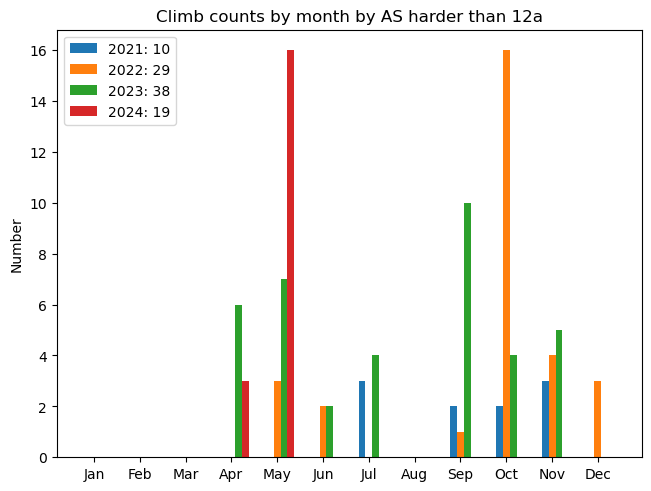

In [29]:
grouped_bar_chart(climbs, climber="AS", grade_min="12a")

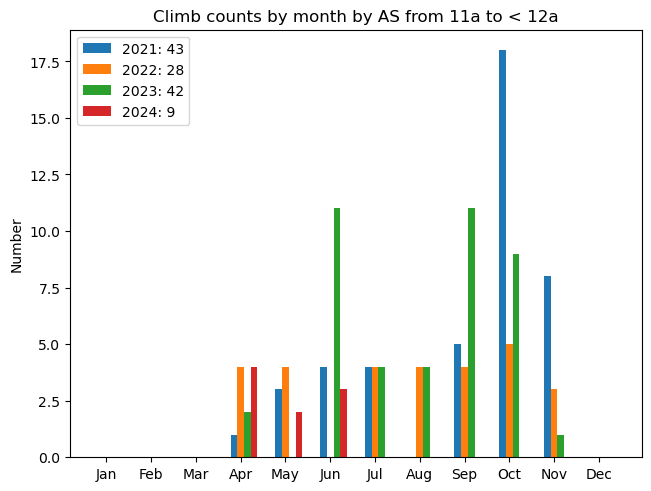

In [30]:
grouped_bar_chart(climbs, climber="AS", grade_min="11a", grade_max="12a")

In [31]:
Grade("5.11") == Grade("11a/b")

False